In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

In [3]:
df = pd.concat([train_df, test_df], ignore_index=True) # У данной задачи есть два датасета - один, на котором модель обучается(train),
# другой - на котором надо модель проверять и затем сабмитить. Я их объединил, чтобы все последующие преобразования проводить одновременно.
# Далее я их разделю обратно на два датасета(стоит отметить, что в train датасет - 891 строка)

In [4]:
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [5]:
train_df['Age'].iloc[:5].describe()

count     5.00000
mean     31.20000
std       6.83374
min      22.00000
25%      26.00000
50%      35.00000
75%      35.00000
max      38.00000
Name: Age, dtype: float64

In [6]:
# Хочу заметить, что я специально объединенный датасет назвал как train_df, потому что изначально я писал код для работы с данными отдельно ддля каждого
# датасета. Чтобы не менять код, я просто назвал объединенный датасет так же, как и train.
train_df = df # Поэтому я просто присвою объединенный df в переменную train_df. В дальнейшем, датасеты будут разделены как надо под своими именами.
rows, cols = train_df.shape

In [7]:
import warnings
warnings.simplefilter("ignore")

prev_idx = 0
for i in range(10, rows, 10):
    local_mean = train_df['Age'].iloc[prev_idx:i].describe()['mean']
    train_df['Age'].loc[prev_idx:i] = train_df['Age'].loc[prev_idx:i].fillna(local_mean)
    prev_idx = i
train_df.isnull().sum()

    

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               4
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [8]:
def extract_last_name(full_name):
    return full_name.split()[0][:-1]

train_df['Name'] = train_df['Name'].apply(extract_last_name)

In [9]:
train_df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [10]:
def extract_letter_from_cabin(cabin):
    if isinstance(cabin, str):
        splitted = cabin.split()
        if len(splitted) == 1:
            return splitted[0][0]
        for x in splitted:
            for n in '0123456789':
                if n in x:
                    return x[0]
            
train_df['Cabin'] = train_df['Cabin'].apply(extract_letter_from_cabin)

In [11]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,Braund,male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1.0,1,Cumings,female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1.0,3,Heikkinen,female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1.0,1,Futrelle,female,35.0,1,0,113803,53.1000,C,S
4,5,0.0,3,Allen,male,35.0,0,0,373450,8.0500,None,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,Spector,male,NaN,0,0,A.5. 3236,8.0500,None,S
1305,1306,NaN,1,Oliv,female,39.0,0,0,PC 17758,108.9000,C,C
1306,1307,NaN,3,Saether,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,None,S
1307,1308,NaN,3,Ware,male,NaN,0,0,359309,8.0500,None,S


In [12]:
train_df.Embarked.value_counts()

Embarked
S    914
C    270
Q    123
Name: count, dtype: int64

In [13]:
train_df['Cabin'] = train_df['Cabin'].fillna('0')

for i in range(rows):
    if type(train_df["Embarked"].iloc[i]) == type(np.nan):
        train_df["Embarked"].loc[i] = "S" # Самое популярное место отправки

In [14]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,Braund,male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1.0,1,Cumings,female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1.0,3,Heikkinen,female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1.0,1,Futrelle,female,35.0,1,0,113803,53.1000,C,S
4,5,0.0,3,Allen,male,35.0,0,0,373450,8.0500,0,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,Spector,male,NaN,0,0,A.5. 3236,8.0500,0,S
1305,1306,NaN,1,Oliv,female,39.0,0,0,PC 17758,108.9000,C,C
1306,1307,NaN,3,Saether,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,0,S
1307,1308,NaN,3,Ware,male,NaN,0,0,359309,8.0500,0,S


In [15]:
mean_age = train_df.tail()['Age'].mean()

train_df['Fare'] = train_df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.mean()))
train_df['Age'] = train_df['Age'].fillna(mean_age)

# Этот код я использовал, когда объединил датасет трейна с тестом, в тестовом датасете есть пропущенные значения в столбце Age.

In [16]:
train_df.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
dtype: int64

In [17]:
train_df['TotalRelatives'] = train_df['Parch'] + train_df['SibSp']


In [18]:
#train_df.groupby(['Pclass'])['Sex'].value_counts()
unique_cabins = list(train_df['Cabin'].unique())

In [19]:
unique_names = list(train_df['Name'].unique())

In [20]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

result = OneHotEncoder().fit_transform(train_df['Sex'].values.reshape(-1, 1)).toarray()

train_df[['Female', 'Male']] = pd.DataFrame(result, index = train_df.index)

result = OneHotEncoder().fit_transform(train_df['Embarked'].values.reshape(-1, 1)).toarray()

train_df[['Cherbourg', 'Queenstown', 'Southampton']] = pd.DataFrame(result, index = train_df.index)

result = OneHotEncoder().fit_transform(train_df['Cabin'].values.reshape(-1, 1)).toarray()

train_df[unique_cabins] = pd.DataFrame(result, index = train_df.index)

LE = LabelEncoder()
LE.fit(unique_names)
train_df['Name'] = LE.fit_transform(train_df['Name'])
train_df = train_df.drop(['Sex', 'Embarked', 'Ticket', 'Cabin'], axis=1)

In [21]:
#train_df['Cabin'].nunique()
#train_df = train_df.drop(['Cabin'], axis=1)

In [22]:
#train_df = train_df.drop(['Sex', 'Embarked', 'Ticket'], axis=1)

In [23]:
train_df

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Fare,TotalRelatives,Female,...,Southampton,0,C,E,G,D,A,B,F,T
0,1,0.0,3,100,22.00,1,0,7.2500,1,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.0,1,182,38.00,1,0,71.2833,1,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,3,329,26.00,0,0,7.9250,0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1.0,1,267,35.00,1,0,53.1000,1,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,3,15,35.00,0,0,8.0500,0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,753,38.75,0,0,8.0500,0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1305,1306,NaN,1,593,39.00,0,0,108.9000,0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1306,1307,NaN,3,699,38.50,0,0,7.2500,0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1307,1308,NaN,3,823,38.75,0,0,8.0500,0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
survived_col = train_df["Survived"][:891]

In [25]:
train_df = train_df.drop(["Survived"], axis=1)

In [69]:
test_df

,PassengerId,Pclass,Name,Age,SibSp,Parch,Fare,TotalRelatives,Female,Male,...,Southampton,0,C,E,G,D,A,B,F,T
891,892,3,401,34.50,0,0,7.8292,0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
892,893,3,842,47.00,1,0,7.0000,1,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
893,894,2,552,62.00,0,0,9.6875,0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
894,895,3,850,27.00,0,0,8.6625,0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
895,896,3,342,22.00,1,1,12.2875,2,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,753,38.75,0,0,8.0500,0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1305,1306,1,593,39.00,0,0,108.9000,0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1306,1307,3,699,38.50,0,0,7.2500,0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1307,1308,3,823,38.75,0,0,8.0500,0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# Как я и говорил ранее, я объединенный датасет делю на два - train и test.
# Хочу заметить, что я специально объединенный датасет назвал как train_df, потому что изначально я писал код для работы с данными отдельно ддля каждого
# датасета. Чтобы не менять код, я просто назвал объединенный датасет так же, как и train.
test_df = train_df[891:]  # 891, потому что в изначальном датасете для train ("/kaggle/input/titanic/train.csv") 891 строка. Следовательно, все остальные строки 
# из объединенного датасета - они от датасета test ("/kaggle/input/titanic/test.csv").
train_df = train_df[:891] 
train_df

,PassengerId,Pclass,Name,Age,SibSp,Parch,Fare,TotalRelatives,Female,Male,...,Southampton,0,C,E,G,D,A,B,F,T
0,1,3,100,22.000000,1,0,7.2500,1,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,182,38.000000,1,0,71.2833,1,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3,3,329,26.000000,0,0,7.9250,0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,267,35.000000,1,0,53.1000,1,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,3,15,35.000000,0,0,8.0500,0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,535,27.000000,0,0,13.0000,0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
887,888,1,294,19.000000,0,0,30.0000,0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
888,889,3,383,27.111111,1,2,23.4500,3,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
889,890,1,69,26.000000,0,0,30.0000,0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(train_df)

scaled_df_train = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns, index=train_df.index)

scaler.fit(test_df)

scaled_df_test = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns, index=test_df.index)

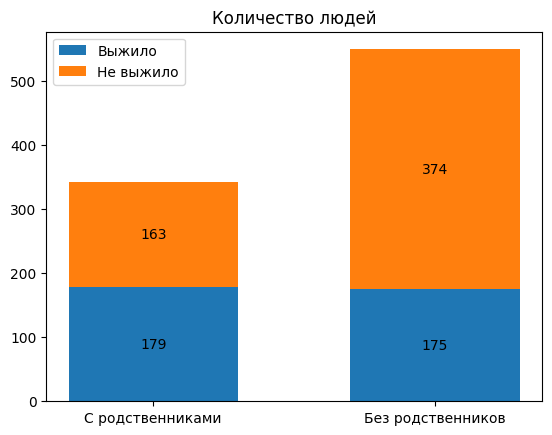

In [47]:
# Теперь, мы имеем преобразованный датасет train_df ("/kaggle/input/titanic/train.csv").
# Проведем некоторую аналитику и построим графики.
# 1. Предположим, что те люди, у которых не было родственников на борту, выживали чаще, чем те, у кого они были.
import matplotlib.pyplot as plt
survived_with_relatives = len(train_df[(train_df.TotalRelatives > 0) & (train_df.Survived == 1.0)])
not_survived_with_relatives = len(train_df[(train_df.TotalRelatives > 0) & (train_df.Survived == 0)])
survived_without_relatives = len(train_df[(train_df.TotalRelatives == 0) & (train_df.Survived == 1.0)])
not_survived_without_relatives = len(train_df[(train_df.TotalRelatives == 0) & (train_df.Survived == 0)])
name = ('С родственниками', 'Без родственников')
labels = {
    'Выжило': np.array([survived_with_relatives, not_survived_with_relatives]),
    'Не выжило': np.array([survived_without_relatives, not_survived_without_relatives]),
}
width = 0.6 


fig, ax = plt.subplots()
bottom = np.zeros(2)

for label, amount in labels.items():
    p = ax.bar(name, amount, width, label=label, bottom=bottom)
    bottom += amount

    ax.bar_label(p, label_type='center')

ax.set_title('Количество людей')
ax.legend()

plt.show()
# Как оказалось, не смотря на то, что количество выживших людей с родственниками и без примерно одинаково, именно люди, у которых были родственнии, выживали чаще
# Хотя общее количество людей без родственников, конечно, больше, чем с родственниками.

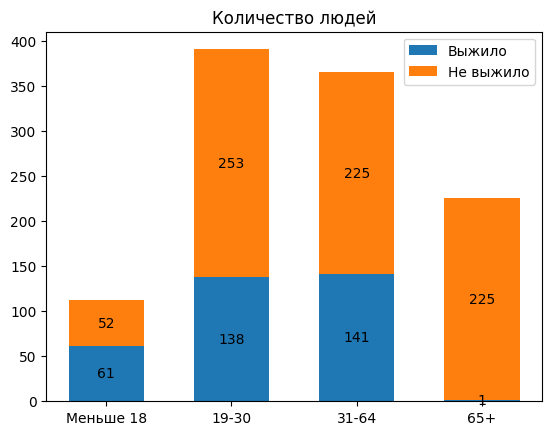

In [48]:
# 2. Проверим гипотезу о том, что выживание зависит от возраста. Для этого, я разделю всех на 4 группы: 0-17 лет - дети, 18-30 - взрослые, 31-64 - взрослые, 65+ - пожилые
# Я мог записать взрослых в одну группу от 18-64, но решил разделить на две для наглядности.
under_18_survived = len(train_df[(train_df.Age < 18) & (train_df.Survived == 1.0)])
under_18_not_survived = len(train_df[(train_df.Age < 18) & (train_df.Survived == 0)])

from_18_to_30_survived = len(train_df[((train_df.Age >= 18) & (train_df.Age <= 30)) & (train_df.Survived == 1)])
from_18_to_30_not_survived = len(train_df[((train_df.Age >= 18) & (train_df.Age <= 30)) & (train_df.Survived == 0)])

from_31_to_64_survived = len(train_df[((train_df.Age >= 31) & (train_df.Age <= 64)) & (train_df.Survived == 1)])
from_31_to_64_not_survived = len(train_df[((train_df.Age >= 31) & (train_df.Age <= 64)) & (train_df.Survived == 0)])

over_65_survived = len(train_df[(train_df.Age > 64) & (train_df.Survived == 1.0)])
over_65_not_survived = len(train_df[(train_df.Age > 64) & (train_df.Survived == 0)])


name = ('Меньше 18', '19-30', '31-64', '65+')
labels = {
    'Выжило': np.array([under_18_survived, from_18_to_30_survived, from_31_to_64_survived, over_65_survived]),
    'Не выжило': np.array([under_18_not_survived, from_18_to_30_not_survived, from_31_to_64_not_survived, from_31_to_64_not_survived]),
}
width = 0.6 


fig, ax = plt.subplots()
bottom = np.zeros(4)

for label, amount in labels.items():
    p = ax.bar(name, amount, width, label=label, bottom=bottom)
    bottom += amount

    ax.bar_label(p, label_type='center')

ax.set_title('Количество людей')
ax.legend()

plt.show()
# Можем заметить, что из возрастной группы 65+ выжил только один. А вот в группе "меньше 18"
# выжило более половины. Можно сделать вывод, что возраст играет одну из важнейших ролей
# в выживании. Это можно использовать при дальнейшем обучении модели.

([<matplotlib.patches.Wedge at 0x7c012c9cd4e0>,
 [Text(0.5056813863013835, 0.976875803543271, '3 класс'),
  Text(-1.0866148078690505, 0.17107968704585155, '2 класс'),
  Text(0.34759762104495984, -1.0436359009941565, '1 класс')])

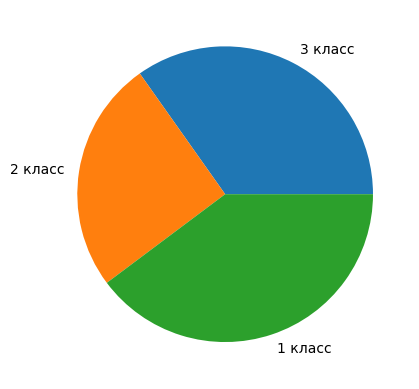

In [49]:
# Теперь посмотрим зависимость класса билета и выживаемости.

class_3_survived = len(train_df[(train_df.Pclass == 3) & (train_df.Survived == 1)])
class_2_survived = len(train_df[(train_df.Pclass == 2) & (train_df.Survived == 1)])
class_1_survived = len(train_df[(train_df.Pclass == 1) & (train_df.Survived == 1)])

labels = ["3 класс", "2 класс", "1 класс"]
nums = [class_3_survived, class_2_survived, class_1_survived]

fig, ax = plt.subplots()
ax.pie(nums, labels=labels)
# Можно заметить, что 1 и 3 классы примерно равны и больше, чем 2 класс. То есть
# можно предположить, что люди, купившие билет класса 1 или 3 выживают чаще,
# чем те, кто купил 2 класс. Но проверим эту гипотезу.

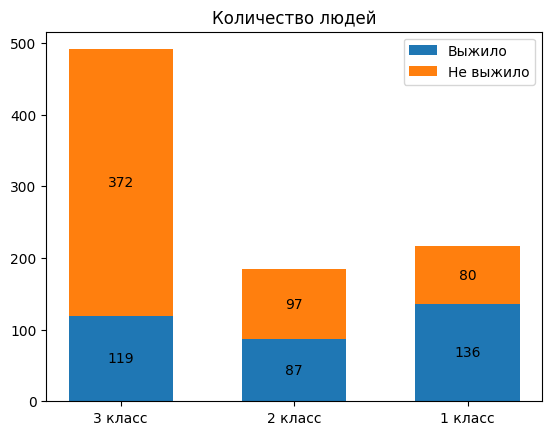

In [50]:
# Для этого, сделаем тот же график, что и в предыдущих двух, где отобразим не только
# выживших, но и погибших.

class_3_survived = len(train_df[(train_df.Pclass == 3) & (train_df.Survived == 1)])
class_2_survived = len(train_df[(train_df.Pclass == 2) & (train_df.Survived == 1)])
class_1_survived = len(train_df[(train_df.Pclass == 1) & (train_df.Survived == 1)])
class_3_not_survived = len(train_df[(train_df.Pclass == 3) & (train_df.Survived == 0)])
class_2_not_survived = len(train_df[(train_df.Pclass == 2) & (train_df.Survived == 0)])
class_1_not_survived = len(train_df[(train_df.Pclass == 1) & (train_df.Survived == 0)])

name = ('3 класс', '2 класс', '1 класс')
labels = {
    'Выжило': np.array([class_3_survived, class_2_survived, class_1_survived]),
    'Не выжило': np.array([class_3_not_survived, class_2_not_survived, class_1_not_survived]),
}
width = 0.6 


fig, ax = plt.subplots()
bottom = np.zeros(3)

for label, amount in labels.items():
    p = ax.bar(name, amount, width, label=label, bottom=bottom)
    bottom += amount

    ax.bar_label(p, label_type='center')

ax.set_title('Количество людей')
ax.legend()

plt.show()
# Теперь становится ясно, что наше предположение оказалось не совсем верным.
# Те, у кого был 3 класс - выживали гораздо реже(при том больше всего купленных билетов), 
# чем те, кто купил 2 класс или 1, причем люди в первом классе выживали чаще всего

In [51]:
train_df.sum()

PassengerId       397386.000000
Survived             342.000000
Pclass              2057.000000
Name              382131.000000
Age                26539.431314
SibSp                466.000000
Parch                340.000000
Fare               28693.949300
TotalRelatives       806.000000
Female               314.000000
Male                 577.000000
Cherbourg            168.000000
Queenstown            77.000000
Southampton          646.000000
0                    687.000000
C                     15.000000
E                     47.000000
G                     59.000000
D                     33.000000
A                     33.000000
B                      9.000000
F                      7.000000
T                      1.000000
dtype: float64

([<matplotlib.patches.Wedge at 0x7c012c89cfa0>,
 [Text(1.0858588526903141, 0.17581396996278398, 'C'),
  Text(0.4756481739950597, 0.9918461647731294, 'E'),
  Text(-1.0076171015068751, 0.4412570415878751, 'G'),
  Text(-0.6280611262028061, -0.9030721021894449, 'D'),
  Text(0.5644984509916647, -0.9441088384439641, 'A'),
  Text(1.051483484946827, -0.3230827771393518, 'B'),
  Text(1.095375790447749, -0.1007565268405433, 'F'),
  Text(1.0997107953611804, -0.025222342596991246, 'T')])

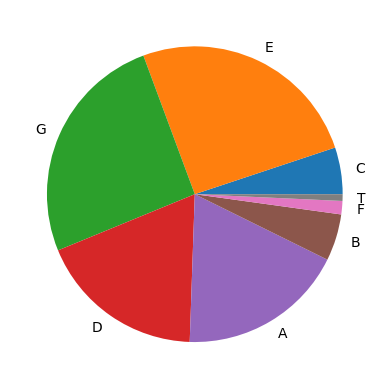

In [52]:
# Еще хочется проверить, зависит ли как-то буква каюты (A, B, C...) и то, выжил или нет человек
C = len(train_df[(train_df.C == 1) & (train_df.Survived == 1)])
E = len(train_df[(train_df.E == 1) & (train_df.Survived == 1)])
G = len(train_df[(train_df.G == 1) & (train_df.Survived == 1)])
D = len(train_df[(train_df.D == 1) & (train_df.Survived == 1)])
A = len(train_df[(train_df.A == 1) & (train_df.Survived == 1)])
B = len(train_df[(train_df.B == 1) & (train_df.Survived == 1)])
F = len(train_df[(train_df.F == 1) & (train_df.Survived == 1)])
T = len(train_df[(train_df['T'] == 1) & (train_df.Survived == 0)])
labels = unique_cabins[1:]
nums = [C, E, G, D, A, B, F, T]
fig, ax = plt.subplots()
ax.pie(nums, labels=labels)
# Таким образом, люди из кают G и E выжило больше.

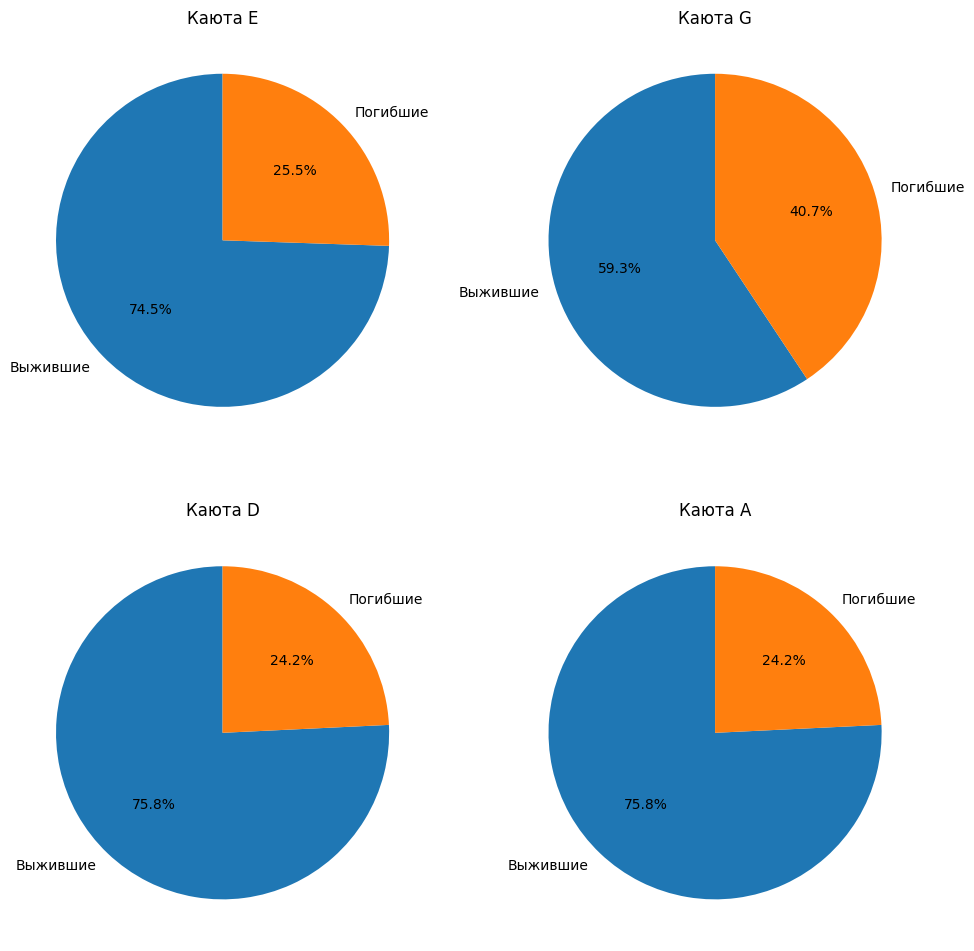

In [53]:
# Рассмотрим те каюты, в которых выжило большее количество человек: A, D, G, E.
# Найдем общее отношение выживших ко всему количеству людей.
E_1 = len(train_df[(train_df.E == 1) & (train_df.Survived == 1)])
G_1 = len(train_df[(train_df.G == 1) & (train_df.Survived == 1)])
D_1 = len(train_df[(train_df.D == 1) & (train_df.Survived == 1)])
A_1 = len(train_df[(train_df.A == 1) & (train_df.Survived == 1)])

E_overall = len(train_df[(train_df.E == 1)])
G_overall = len(train_df[(train_df.G == 1)])
D_overall = len(train_df[(train_df.D == 1)])
A_overall = len(train_df[(train_df.A == 1)])

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].pie([E_1, E_overall - E_1], labels=["Выжившие", "Погибшие"], autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title("Каюта E")

axes[0, 1].pie([G_1, G_overall - G_1], labels=["Выжившие", "Погибшие"], autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title("Каюта G")

axes[1, 0].pie([D_1, D_overall - D_1], labels=["Выжившие", "Погибшие"], autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title("Каюта D")

axes[1, 1].pie([A_1, A_overall - A_1], labels=["Выжившие", "Погибшие"], autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title("Каюта A")

plt.tight_layout()
plt.show()

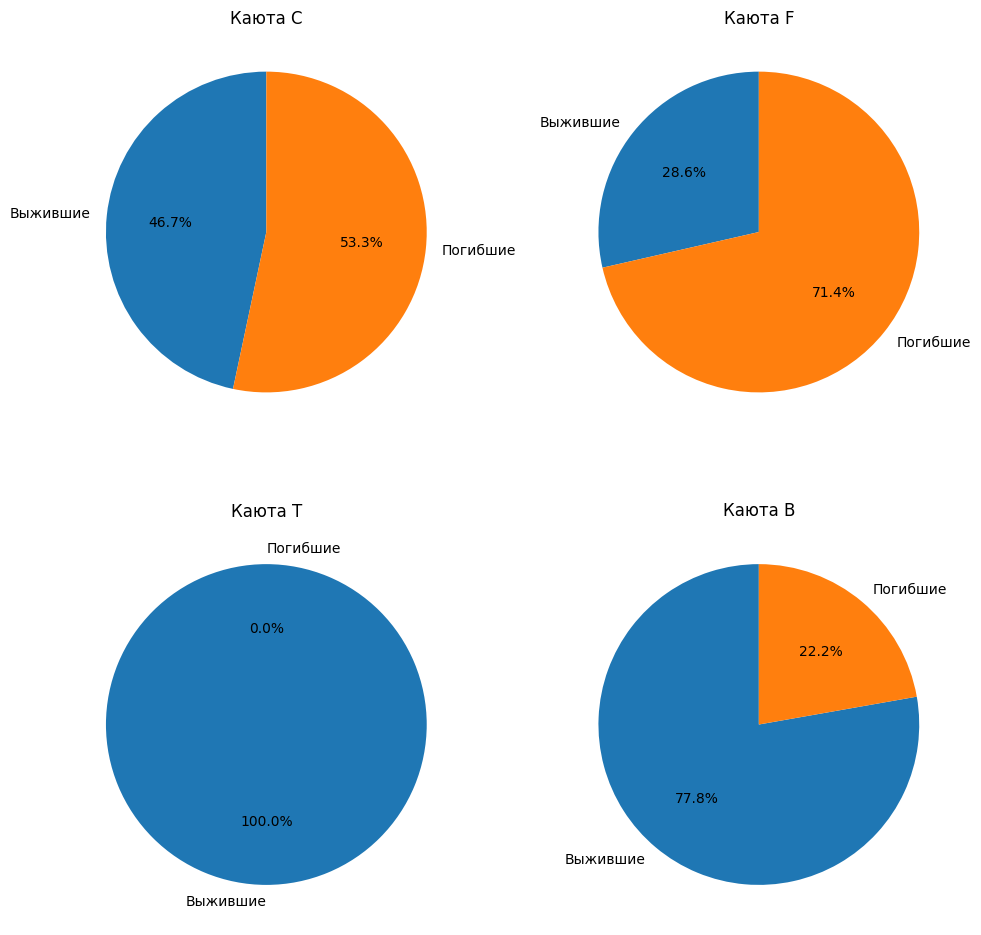

In [55]:
# А теперь те, где выжило меньшее количество людей: C, T, F, B
C_1 = len(train_df[(train_df.C == 1) & (train_df.Survived == 1)])
F_1 = len(train_df[(train_df.F == 1) & (train_df.Survived == 1)])
T_1 = len(train_df[(train_df.T == 1) & (train_df.Survived == 1)])
B_1 = len(train_df[(train_df.B == 1) & (train_df.Survived == 1)])

C_overall = len(train_df[(train_df.C == 1)])
F_overall = len(train_df[(train_df.F == 1)])
T_overall = len(train_df[(train_df.T == 1)])
B_overall = len(train_df[(train_df.B== 1)])

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].pie([C_1, C_overall - C_1], labels=["Выжившие", "Погибшие"], autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title("Каюта C")

axes[0, 1].pie([F_1, F_overall - F_1], labels=["Выжившие", "Погибшие"], autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title("Каюта F")

axes[1, 0].pie([T_1, T_overall - T_1], labels=["Выжившие", "Погибшие"], autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title("Каюта T")

axes[1, 1].pie([B_1, B_overall - B_1], labels=["Выжившие", "Погибшие"], autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title("Каюта B")

plt.tight_layout()
plt.show()

In [28]:
train_df

,PassengerId,Pclass,Name,Age,SibSp,Parch,Fare,TotalRelatives,Female,Male,...,Southampton,0,C,E,G,D,A,B,F,T
0,1,3,100,22.000000,1,0,7.2500,1,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,182,38.000000,1,0,71.2833,1,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3,3,329,26.000000,0,0,7.9250,0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,267,35.000000,1,0,53.1000,1,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,3,15,35.000000,0,0,8.0500,0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,535,27.000000,0,0,13.0000,0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
887,888,1,294,19.000000,0,0,30.0000,0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
888,889,3,383,27.111111,1,2,23.4500,3,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
889,890,1,69,26.000000,0,0,30.0000,0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
survived_col.to_csv("survived.csv") # Я скачивал датасет, чтобы подобрать параметры при помощи GridSearch уже на своем компьютере, тут почему-то это происходит медленно

In [309]:
survived_col = train_df["Survived"][:891]
scaled_df_train = scaled_df_train.drop(["Survived"], axis=1)
scaled_df_train = scaled_df_train.drop(["PassengerId"], axis=1)

In [241]:
train_df.corr()

,Pclass,Name,Age,SibSp,Parch,Fare,TotalRelatives,Female,Male,Cherbourg,...,Southampton,0,C,E,G,D,A,B,F,T
Pclass,1.000000,0.051636,-0.319904,0.083081,0.018443,-0.549500,0.065997,-0.131900,0.131900,-0.243292,...,0.074053,0.725541,-0.204934,-0.369572,-0.417048,-0.278690,-0.221793,-0.023879,0.073625,-0.052496
Name,0.051636,1.000000,0.053564,-0.015708,-0.047285,-0.047542,-0.034358,-0.021213,0.021213,0.001026,...,-0.010445,0.032445,-0.005532,-0.086089,0.001736,0.004141,0.000494,-0.005639,0.080561,-0.045764
Age,-0.319904,0.053564,1.000000,-0.227232,-0.179698,0.090698,-0.245079,-0.083522,0.083522,0.023797,...,-0.017068,-0.223650,0.113504,0.088151,0.107211,0.133746,0.107015,-0.083795,-0.060876,0.038457
SibSp,0.083081,-0.015708,-0.227232,1.000000,0.414838,0.159651,0.890712,0.114631,-0.114631,-0.059528,...,0.068734,0.040460,-0.046266,-0.034538,0.029251,-0.017575,-0.033751,0.013167,-0.019159,-0.015907
Parch,0.018443,-0.047285,-0.179698,0.414838,1.000000,0.216225,0.783111,0.245489,-0.245489,-0.011069,...,0.060814,-0.036987,-0.040325,0.056498,0.030736,-0.019125,-0.011748,0.035745,0.036749,-0.015878
Fare,-0.549500,-0.047542,0.090698,0.159651,0.216225,1.000000,0.217138,0.182333,-0.182333,0.269335,...,-0.162184,-0.482075,0.019549,0.386297,0.364318,0.098878,0.051749,-0.020811,-0.037921,0.002224
TotalRelatives,0.065997,-0.034358,-0.245079,0.890712,0.783111,0.217138,1.000000,0.200988,-0.200988,-0.046215,...,0.077359,0.009175,-0.051767,0.004620,0.035347,-0.021566,-0.028937,0.026857,0.005264,-0.018804
Female,-0.131900,-0.021213,-0.083522,0.114631,0.245489,0.182333,0.200988,1.000000,-1.000000,0.082853,...,-0.119224,-0.140391,-0.078271,0.109689,0.058649,0.079248,0.054368,0.019460,0.040796,-0.024728
Male,0.131900,0.021213,0.083522,-0.114631,-0.245489,-0.182333,-0.200988,-1.000000,1.000000,-0.082853,...,0.119224,0.140391,0.078271,-0.109689,-0.058649,-0.079248,-0.054368,-0.019460,-0.040796,0.024728
Cherbourg,-0.243292,0.001026,0.023797,-0.059528,-0.011069,0.269335,-0.046215,0.082853,-0.082853,1.000000,...,-0.782742,-0.208528,0.093040,0.168642,0.113952,0.102977,-0.003376,-0.048694,-0.042895,-0.016158


In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(train_df)

scaled_df_train = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns, index=train_df.index)

In [30]:
scaled_df_train = scaled_df_train.drop(['PassengerId'], axis=1)

In [31]:
scaled_df_train

,Pclass,Name,Age,SibSp,Parch,Fare,TotalRelatives,Female,Male,Cherbourg,...,Southampton,0,C,E,G,D,A,B,F,T
0,0.827377,-1.301919,-0.587146,0.432793,-0.473674,-0.502445,0.059160,-0.737695,0.737695,-0.482043,...,0.615838,0.544925,-0.130856,-0.235981,-0.266296,-0.196116,-0.196116,-0.101015,-0.088986,-0.03352
1,-1.566107,-0.977309,0.619403,0.432793,-0.473674,0.786845,0.059160,1.355574,-1.355574,2.074505,...,-1.623803,-1.835115,-0.130856,-0.235981,3.755222,-0.196116,-0.196116,-0.101015,-0.088986,-0.03352
2,0.827377,-0.395386,-0.285508,-0.474545,-0.473674,-0.488854,-0.560975,1.355574,-1.355574,-0.482043,...,0.615838,0.544925,-0.130856,-0.235981,-0.266296,-0.196116,-0.196116,-0.101015,-0.088986,-0.03352
3,-1.566107,-0.640823,0.393175,0.432793,-0.473674,0.420730,0.059160,1.355574,-1.355574,-0.482043,...,0.615838,-1.835115,-0.130856,-0.235981,3.755222,-0.196116,-0.196116,-0.101015,-0.088986,-0.03352
4,0.827377,-1.638405,0.393175,-0.474545,-0.473674,-0.486337,-0.560975,-0.737695,0.737695,-0.482043,...,0.615838,0.544925,-0.130856,-0.235981,-0.266296,-0.196116,-0.196116,-0.101015,-0.088986,-0.03352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.369365,0.420098,-0.210099,-0.474545,-0.473674,-0.386671,-0.560975,-0.737695,0.737695,-0.482043,...,0.615838,0.544925,-0.130856,-0.235981,-0.266296,-0.196116,-0.196116,-0.101015,-0.088986,-0.03352
887,-1.566107,-0.533939,-0.813373,-0.474545,-0.473674,-0.044381,-0.560975,1.355574,-1.355574,-0.482043,...,0.615838,-1.835115,-0.130856,4.237623,-0.266296,-0.196116,-0.196116,-0.101015,-0.088986,-0.03352
888,0.827377,-0.181618,-0.201720,0.432793,2.008933,-0.176263,1.299429,1.355574,-1.355574,-0.482043,...,0.615838,0.544925,-0.130856,-0.235981,-0.266296,-0.196116,-0.196116,-0.101015,-0.088986,-0.03352
889,-1.566107,-1.424637,-0.285508,-0.474545,-0.473674,-0.044381,-0.560975,-0.737695,0.737695,2.074505,...,-1.623803,-1.835115,-0.130856,-0.235981,3.755222,-0.196116,-0.196116,-0.101015,-0.088986,-0.03352


In [51]:
from sklearn.model_selection import train_test_split

X = scaled_df_train
y = survived_col


x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True)

In [ ]:
'''Для начала рассмотрим SVM, так как она довольно неплохо показывает себя на датасетах, где мало данных (судя по информации из Интернета и документации).'''

In [33]:
from sklearn import svm
clf = svm.SVC(kernel='poly', C=20).fit(x_train, y_train)
clf.score(x_test, y_test)

0.7623318385650224

In [68]:
# Кросс-валидация на svm.SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC

# Определение параметров для GridSearch
param_grid = {
    'C': [4, 5, 6], 
    'degree': [5, 6, 7],   
    'coef0': [1, 1.1, 1.15],
}
# param_grid = {
#     'C': [7, 8, 9], 
#     'degree': [8, 9, 10],   
#     'coef0': [1, 1.1, 1.15],
# }

clf = SVC(kernel='poly', tol=1e-5) 

grid_search = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')

grid_search.fit(X, y)

print(f"Лучшие параметры: {grid_search.best_params_}")

best_clf = grid_search.best_estimator_ 
scores = cross_val_score(best_clf, X, y, cv=10) # Собственно, сама кросс-валидация

print(f"Результаты кросс-валидации: {scores}")
print(f'Средняя точность {scores.mean()}', f'Лучшая точность: {scores.max()}', sep='\n')

Лучшие параметры: {'C': 4, 'coef0': 1, 'degree': 5}
Результаты кросс-валидации: [0.76666667 0.82022472 0.75280899 0.78651685 0.87640449 0.79775281
 0.82022472 0.82022472 0.83146067 0.83146067]
Средняя точность 0.8103745318352059
Лучшая точность: 0.8764044943820225


In [35]:
# Создаем модель с лучшими параметрами 
# Здесь указано несколько лучших параметров, так как я запускал grid search при разных значениях. Я не могу указать все сразу, так как выполнялось бы слишком долго.
# Лучшие параметры: {'C': 1, 'coef0': 1.2, 'degree': 2}
# Лучшие параметры: {'C': 2, 'coef0': 1.1, 'degree': 3}
#Лучшие параметры: {'C': 4, 'coef0': 1, 'degree': 5}
clf = SVC(kernel='poly', C=1, coef0=1, degree=2, tol=1e-5)
clf.fit(x_train, y_train)

SVC(C=1, coef0=1, degree=2, kernel='poly', tol=1e-05)

In [ ]:
'''Попробуем написать модель самостоятельно. Будем использовать и регуляризаторы, и метод EarlyStopping, чтобы избежать переобучения.
Сначала создадим модель с большим количеством слоев, и потом будем отталкиваться от результатов'''

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import cross_val_score


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=l2(0.02)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(4, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(2, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=500, batch_size=8, validation_split=0.1, verbose=0,
          callbacks=[early_stopping])

loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8039 - loss: 0.5740 
Test Accuracy: 0.78


In [ ]:
'''Попробуем увеличить кол-во слоев'''

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=l2(0.02)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(4, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(2, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=500, batch_size=8, validation_split=0.1, verbose=0,
          callbacks=[early_stopping])

loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7953 - loss: 0.6153 
Test Accuracy: 0.77


In [ ]:
'''Теперь уменьшим'''

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=l2(0.02)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=500, batch_size=8, validation_split=0.1, verbose=0,
          callbacks=[early_stopping])

loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8103 - loss: 0.5338 
Test Accuracy: 0.79


In [ ]:
'''Уменьшим так же количество нейронов'''

In [250]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=l2(0.01)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=500, batch_size=8, validation_split=0.1, verbose=0,
          callbacks=[early_stopping])

loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8413 - loss: 0.4560 
Test Accuracy: 0.83


In [ ]:
#Самая высокая точность за все время тестов

#7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8295 - loss: 0.5560 
#Test Accuracy: 0.85

'''Можно сделать вывод, что лучше себя показывает модель, которая проще по архитектуре. (Оно и понятно: данных мало - модель попроще обучить легче, чем модель с большим
количеством слоев).'''

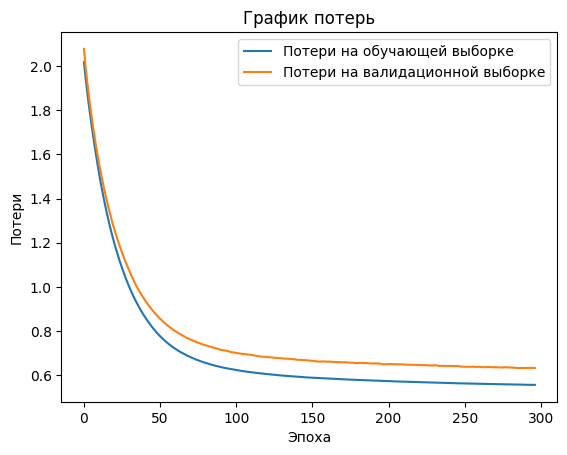

In [234]:
import numpy as np
import matplotlib.pyplot as plt

loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

plt.title("График потерь")
plt.plot(loss, label="Потери на обучающей выборке")
plt.plot(val_loss, label="Потери на валидационной выборке")
plt.xlabel("Эпоха")
plt.ylabel("Потери")
plt.legend()
plt.show()


In [ ]:
'''Попробуем теперь GradientBoostingClassifier'''

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

GBC = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 0.3, 0.001, 0.2],
    'max_depth': [3, 5, 7, 9, 11],
    
}

grid_search = GridSearchCV(estimator=GBC, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_x, train_y)

best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)


In [152]:
train_df = train_df.drop(['PassengerId'], axis=1)
train_df

,Pclass,Name,Age,SibSp,Parch,Fare,TotalRelatives,Female,Male,Cherbourg,...,Southampton,0,C,E,G,D,A,B,F,T
0,3,100,22.000000,1,0,7.2500,1,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,182,38.000000,1,0,71.2833,1,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3,329,26.000000,0,0,7.9250,0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,267,35.000000,1,0,53.1000,1,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,3,15,35.000000,0,0,8.0500,0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,535,27.000000,0,0,13.0000,0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
887,1,294,19.000000,0,0,30.0000,0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
888,3,383,27.111111,1,2,23.4500,3,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
889,1,69,26.000000,0,0,30.0000,0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


[0.10766103 0.10206814 0.1209435  0.0177911  0.00388489 0.08037084
 0.04115342 0.20449626 0.26958939 0.00080152 0.00199538 0.00381669
 0.03065845 0.         0.         0.00338349 0.00159382 0.00979206
 0.         0.         0.        ]


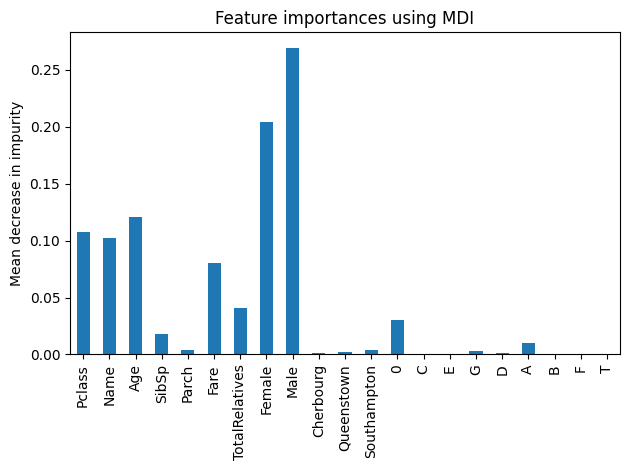

In [237]:
'''На основе данной модели проверим Feature importance.'''
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
GBC = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01,
    max_depth=5, min_samples_leaf=5, min_samples_split=9, 
                                 criterion='squared_error')
GBC.fit(x_train,y_train)
column_names = list(x_train.columns)
feature_names = [column_names[i] for i in range(X.shape[1])]
importances = GBC.feature_importances_
print(importances)
gbc_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
gbc_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


# Заметим, что, если сопоставить график снизу с нашим датасетом, то пол человека
# оказывает самое сильное влияние на обучение модели.


In [204]:
scaled_df_train_2 = scaled_df_train.drop(['C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], axis=1) # Создадим датасет без колонок с каютами

In [235]:
GBC.fit(x_train, y_train) # С каютами

predictions = GBC.predict(x_test)

accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.8475336322869955


In [236]:
GBC.fit(x_train_2, y_train_2) # Без кают

predictions = GBC.predict(x_test_2)

accuracy = accuracy_score(y_test_2, predictions)
print(accuracy)

0.8026905829596412


In [208]:
X = scaled_df_train_2
y = survived_col


x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X, y, shuffle=True)

In [ ]:
'''Наконец, рассмотрим еще одну модель xgb'''

In [239]:
import xgboost as xgb

clf = xgb.XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic', 
                       alpha=1, reg_lambda=1, tree_method='approx')

clf.fit(x_train, y_train)

predictions = clf.predict(x_test)

accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.8295964125560538


In [238]:
clf = xgb.XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic', 
                       alpha=1, reg_lambda=1, tree_method='approx')

clf.fit(x_train_2, y_train_2)

predictions = clf.predict(x_test_2)

accuracy = accuracy_score(y_test_2, predictions)
print(accuracy)

0.7847533632286996


In [ ]:
# Как можем заметить, лучший результат показала модель SVM. Стоит отметить, что Support Vector Machine отлично подходит для обучения на небольшом объеме данных,
# но необходимо сделать предобработку (как в моем случае, при помощи StandardScaler), чтобы не было выбросов (так как SVM неустойчива к ним.)



In [66]:
'''Сделаем кросс-валидацию на лучшей модели - SVM.'''
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

clf = SVC(kernel='poly', tol=1e-5, C=4, coef0=1, degree=5)

kf = KFold(n_splits=10)

for fold_number, (train_index, test_index) in enumerate(kf.split(X), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)

    # Вычисление и вывод метрик для текущего фолда
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    print(f"Номер обхода: {fold_number}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)


Номер обхода: 1
Confusion Matrix:
[[43  8]
 [13 26]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.84      0.80        51
         1.0       0.76      0.67      0.71        39

    accuracy                           0.77        90
   macro avg       0.77      0.75      0.76        90
weighted avg       0.77      0.77      0.76        90

Номер обхода: 2
Confusion Matrix:
[[61  8]
 [ 7 13]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89        69
         1.0       0.62      0.65      0.63        20

    accuracy                           0.83        89
   macro avg       0.76      0.77      0.76        89
weighted avg       0.83      0.83      0.83        89

Номер обхода: 3
Confusion Matrix:
[[46  9]
 [12 22]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.81        55
         

In [ ]:
'''Возьмем один обход, например, 5. Рассмотрим его confusion matrix: [[48  4] [ 9 28]]. Какой вывод:
TP: модель предсказала, что 48 человек выжило, и они действительно выжили;
FP: модель предсказала, что 4 человека выжило, но на самом деле они погибли;
FN: модель предсказала, что 9 человек погибло, но на самом деле они выжили;
TN: модель предсказала, что 28 человек погибло, и они действительно погибли.
Помимо этого, на основе classification report можно сделать вывод, что recall (какую долю объектов положительного класса из всех объектов положительного класса)
для класса 0 составляет 92%, а для класса 1 - 76%; precision (долю объектов, названных классификатором положительными и при этом действительно являющимися положительными)
для класса 0 - 84%, для класса 1 - 88%. В целом, это весьма неплохой результат, и я уверен, что если продолжить поиск лучших параметров для SVM, а также, возможно, как-то
еще поработать с данными (например, сделать колонку с Mr., Miss., и пр. или убрать ненужные колонки (которые практически никак не влияют на модель)), то можно добиться 
лучших результатов.
Как я уже сказал, SVM показала лучший результат. Но что насчет других моделей, которые я использовал? Если посмотреть на модели, которые писались самостоятельно 
(при помощи Keras), то я заметил, что чем меньше слоев, тем лучше показывает себя модель (могу сделать вывод, что это связано с тем, что данных мало, а чем больше слоев,
тем сложнее обучить модель, чтобы она научилась обобщать). Если же смотреть на GradientBoostingClassifier, то, возможно, он не совсем подходит для нашей задачи. Точно не могу
сказать почему, но данная модель показала себя не очень стабильно (она лишь единожды выбивала метрику в 85%, если же менять набор данных, то метрика сильно падала).
XGBoost, возможно, имеет такую же проблему. Поэтому могу сделать вывод, что просто везло в выбором тестового датасета, поэтому получался такой результат.
SVM же показал себя лучше всех, показывая неплохие результаты при разном наборе данных (проверил с помощью cross validation.)
 '''

In [ ]:
# Весь код ниже - я его написал, когда отдельно обрабатывал датасет test.csv.
# По сути, сейчас он не нужен, но я его оставил на всякий случай

In [ ]:
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
test_df.isnull().sum()
rows, cols = test_df.shape

In [ ]:
unique_cabins = test_df['Cabin'].unique()

In [ ]:
prev_idx = 0
for i in range(10, rows, 10):
    local_mean = test_df['Age'].iloc[prev_idx:i].describe()['mean']
    test_df['Age'].loc[prev_idx:i] = test_df['Age'].loc[prev_idx:i].fillna(local_mean)
    prev_idx = i
test_df.isnull().sum()


In [ ]:
def extract_last_name(full_name):
    return full_name.split()[0][:-1]

test_df['Name'] = test_df['Name'].apply(extract_last_name)

In [ ]:
last_indices = test_df.tail().index
mean_age = test_df.tail()['Age'].mean()

test_df.loc[413:418] = test_df.loc[413:418].fillna(mean_age)


In [ ]:
test_df.isnull().sum()

In [ ]:
test_df['Cabin'] = test_df['Cabin'].fillna('0')

In [ ]:

for i in range(rows):
    #print(test_df["Fare"].iloc[i] == np.nan)
    if type(test_df["Embarked"].iloc[i]) == type(np.nan):
        test_df["Embarked"].loc[i] = test_df["Embarked"].loc[i-1]
test_df['Fare'] = test_df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
def extract_letter_from_cabin(cabin):
    if isinstance(cabin, str):
        splitted = cabin.split()
        if len(splitted) == 1:
            return splitted[0][0]
        for x in splitted:
            for n in '0123456789':
                if n in x:
                    return x[0]
            
test_df['Cabin'] = test_df['Cabin'].apply(extract_letter_from_cabin)

In [ ]:
test_df['TotalRelatives'] = test_df['Parch'] + test_df['SibSp']

In [ ]:
unique_names = list(test_df['Name'].unique())

In [ ]:
test_df

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

result = OneHotEncoder().fit_transform(test_df['Sex'].values.reshape(-1, 1)).toarray()

test_df[['Female', 'Male']] = pd.DataFrame(result, index = test_df.index)

result = OneHotEncoder().fit_transform(test_df['Embarked'].values.reshape(-1, 1)).toarray()

test_df[['Cherbourg', 'Queenstown', 'Southampton']] = pd.DataFrame(result, index = test_df.index)

result = OneHotEncoder().fit_transform(test_df['Cabin'].values.reshape(-1, 1)).toarray()

test_df[unique_cabins] = pd.DataFrame(result, index = test_df.index)

LE = LabelEncoder()
LE.fit(unique_names)
test_df['Name'] = LE.fit_transform(test_df['Name'])

test_df = test_df.drop(['Embarked', 'Ticket', 'Cabin'], axis=1)

In [ ]:
test_df = test_df.drop(['Sex'], axis=1)

In [ ]:
test_df["T"] = 0

In [ ]:
test_df

In [199]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
passengerId_col = test_df['PassengerId']
test_df = test_df.drop(['Survived'], axis=1)
test_df = test_df.drop(['PassengerId'], axis=1)
scaler.fit(test_df)

scaled_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns, index=test_df.index)

In [200]:
test_df

,Pclass,Name,Age,SibSp,Parch,Fare,TotalRelatives,Female,Male,Cherbourg,...,Southampton,0,C,E,G,D,A,B,F,T
891,3,401,34.50,0,0,7.8292,0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
892,3,842,47.00,1,0,7.0000,1,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
893,2,552,62.00,0,0,9.6875,0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
894,3,850,27.00,0,0,8.6625,0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
895,3,342,22.00,1,1,12.2875,2,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,753,38.75,0,0,8.0500,0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1305,1,593,39.00,0,0,108.9000,0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1306,3,699,38.50,0,0,7.2500,0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1307,3,823,38.75,0,0,8.0500,0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [422]:
predictions = model.predict(test_df)
predictions_binary = (predictions > 0.5).astype(int)
predictions_flattened = [item for sublist in predictions_binary for item in sublist]
print(predictions_flattened)
new_df = pd.concat([pd.DataFrame([i for i in range(892, 1310)]), pd.DataFrame(predictions_flattened, dtype=int)], axis=1)

new_df.to_csv('Submission.csv', index=False, header=["PassengerId", "Survived"])
#0.76

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

In [201]:
predictions = clf.predict(scaled_df)
print(sum(predictions))
new_df = pd.concat([pd.DataFrame([i for i in range(892, 1310)]), pd.DataFrame(predictions)], axis=1)
new_df.to_csv('Submission.csv', index=False, header=["PassengerId", "Survived"])
new_df
#0.776

67


,0,0
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,0


In [251]:
scaled_df_test = scaled_df_test.drop(['PassengerId'], axis=1)


In [253]:
scaled_df_test = scaled_df_test.drop(['Survived'], axis=1)

In [254]:
predictions = clf.predict(scaled_df_test)

passenger_ids = pd.DataFrame({'PassengerId': range(892, 1310)})
results = pd.DataFrame({'Survived': predictions}, dtype=int)

new_df = pd.concat([passenger_ids, results], axis=1)

new_df.to_csv('Submission.csv', index=False, sep=',')

print(new_df.head())

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- PassengerId
- Survived


In [ ]:
#Я протестировал как модель предиктит на датасете после стандартизирования и без него.
#Оказалось, что без него модель справляется чуть лучше.